# Classification Benchmarking

**The goal of this notebook is to benchmark different algorithms on the classification of the toy dataset, before moving to the next stage that is using them for our real data on the autistic project.**


The algorithms that will be tested are:

* The baseline algorithm is the use of `imputations` techniques (let's say MICE, or Matias' technic) both at training and for the inference.

    
* Imputation using Matias' `custom_imputations` method, that resorts on pdf estimation with kernel. The model is a k dimensional distribution, estimating using a gaussian kernel with optimal bandwidth, handling missing coordinates by imputing them based on the proximity with other data from the training set. The inference for a sample is performed on the subset of coordinates that are known, by computing first the marginal of the k-dimensional distribution on the known axis. Note here that no imputation are performed at inference time, but there are during training. 
        
* The `no_imputations` approach will be used, which consist in estimating several distributions, $f_{X|Z}$, and doing inference using them. No imputation are performed, and the marginals are not used (yet). 
    
* The use of `neural_additive_models` developed in [1] will be tested. This method present an interpretable way of using neural network in this setting.
    
* The use of `XGBoost` will be tested. 



Also, direct use of the $Z$ distributions will be used for classification, usinf 

<ins>Inputs:</ins>

* $(X_n)_n \in \mathbb{R}^K$


* $(Z_n)_n \in [ 0, 1]^K $


<ins>Outputs:</ins>

* $(Y_n)_n \in [ 0, 1]$

We would like to show:

* Do a benchmarking of the different methods. 
* If encoding the Nans, is it necessary to add the Z variables ?
* SEE TABLE and come up with experiments. 


    
    
<ins>Takeaways:</ins>

    * Handling missing data is better than discarding them.
    * ...

[1]. Agarwal, R. et al. Neural Additive Models: Interpretable Machine Learning with Neural Nets. Arxiv (2020).

In [1]:
run init.ipynb

Done.


In [2]:
from model.neural_additive_network.model import NAM

# Introduction - Dataset definition

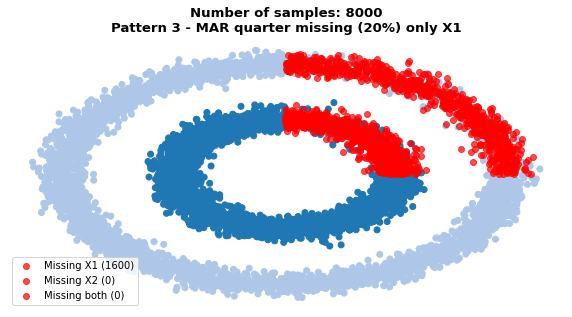

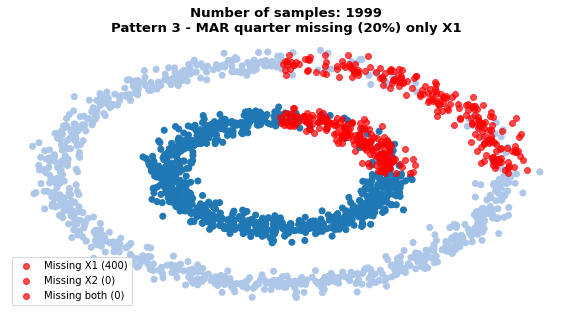

In [2]:
# Dataset default parameters
dataset_name = DATASET_NAME
num_samples = NUM_SAMPLES
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN

# VERBOSITY
verbosity=0



dataset_train = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='train',
                                num_samples=int(proportion_train*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)

dataset_test = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='test',
                                num_samples=int((1-proportion_train)*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)


# Creation of the missingness
dataset_train.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)
dataset_test.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)

dataset_train.plot(title=True)
dataset_test.plot(title=True)

# Get the data
X_test, y_test = dataset_test.get_data()
X_train, y_train = dataset_train.get_data()

# Experiment 1) `no_imputations` approach

Experiment 143 loaded successfully! :-)


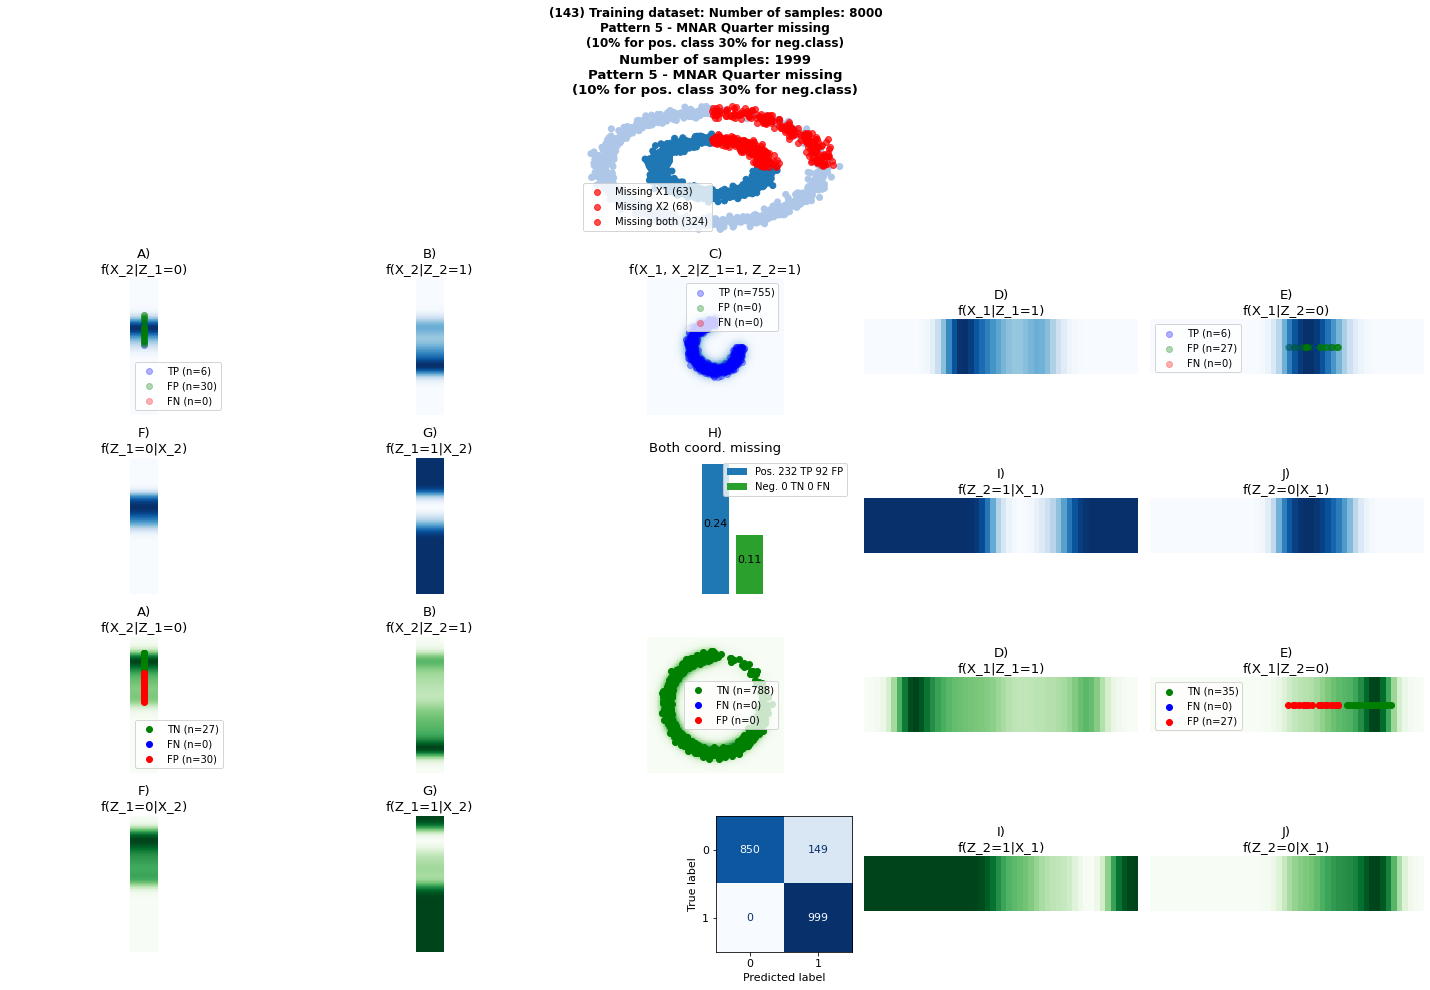

Sample: 999 positive and 999 negative samples (#p/#n=100%)



,0
Accuracy,0.925
F1 score (2 PPVxTPR/(PPV+TPR)),0.931
Matthews correlation coefficient (MCC),0.860
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.851
Precision or positive predictive value (PPV),0.870
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.130
False omission rate (FOR=1-NPV),0.000


In [33]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=dataset_train, 
                  dataset_test=dataset_test, 
                  purpose='classification', 
                  previous_experiment=143, 
                  save_experiment=True, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
#exp.fit()

# Estimate the distributions 
#exp.predict()

# Plot results
exp.plot()

# Experiment 2) The `imputations` approach


In [38]:
from utils import estimate_pdf

hat_f = estimate_pdf(data=X_train, method='mice', resolution=resolution, bandwidth=bandwidth)  
hat_f /= hat_f.sum()

KeyboardInterrupt: 

In [ ]:
    xygrid = np.meshgrid(np.linspace(-2.5,2.5,resolution),np.linspace(-2.5,2.5,resolution))
    H,W = xygrid[0].shape
    hat_f = np.zeros_like(xygrid[0])  # init. the pdf estimation

    if method=='our':
        # See documentation
        from stats import kernel_based_pdf_estimation
        h = bandwidth
        for i in range(H):
            for j in range(W):
                x = xygrid[0][i,j]
                y = xygrid[1][i,j]
                hat_f[i,j] = kernel_based_pdf_estimation(data,x=[x,y],h=h)
                
    if method=='missing':
        # See documentation
        from stats import kernel_based_pdf_estimation_z_prior
        h = bandwidth
        for i in range(H):
            for j in range(W):
                x = xygrid[0][i,j]
                y = xygrid[1][i,j]
                hat_f[i,j] = kernel_based_pdf_estimation_z_prior(data,x=[x,y],h=h)  

    if method=='missing_limited_range':
        # See documentation
        from stats import kernel_based_pdf_estimation_z_prior_limited_range
        h = bandwidth

        # Compute the space mask to be sure not to add contribution on expty space, based on the resolution of the space
        m = [not np.isnan(np.sum(data[i,:])) for i in range(data.shape[0])]
        X_prior = data[m,:]
        hist2d, _, _ = np.histogram2d(X_prior[:,0], X_prior[:,1], bins=[np.linspace(-2.5,2.5,resolution), np.linspace(-2.5,2.5,resolution)])
        hist2d_up = np.concatenate([np.concatenate([hist2d, np.zeros((1, W-1))], axis=0), np.zeros((H, 1))], axis=1)
        mask_space = hist2d_up>0
        for i in range(H):
            for j in range(W):
                x = xygrid[0][i,j]
                y = xygrid[1][i,j]
                hat_f[i,j] = kernel_based_pdf_estimation_z_prior_limited_range(data,x=[x,y], put_weight=mask_space[i,j], h=h)  

    if method=='side_spaces':
        # See documentation
        from stats import kernel_based_pdf_estimation_side_spaces
        h = bandwidth
        hat_f_0 = np.zeros_like(xygrid[0])  # init. the pdf estimation
        hat_f_1 = np.zeros_like(xygrid[0])  # init. the pdf estimation
        hat_f_2 = np.zeros_like(xygrid[0])  # init. the pdf estimation

        for i in range(H):
            for j in range(W):
                x = xygrid[0][i,j]
                y = xygrid[1][i,j]
                # Computing contribution on coordinates i, j of hat_f, and coordinate i of hat_f_1 and coordinate j of hat_f_2
                hat_f[i,j], hat_f_0[i,j], hat_f_1[i,j], hat_f_2[i,j] =  kernel_based_pdf_estimation_side_spaces(X=data, x=[x, y], h=h)
                
        # Average the contribution of all i's and j's coordinate
        hat_f_0 = np.mean(hat_f_0)

        # Average the contribution of all j's coordinate on this horizontal line
        hat_f_1 = np.mean(hat_f_1, axis=0)
        
        # Average the contribution of all i's coordinate to form the vertical line
        hat_f_2 = np.mean(hat_f_2, axis=1)   

        return hat_f, hat_f_0, hat_f_1, hat_f_2    
                
    if method=='naive':
        # Ignore missing values
        from stats import kernel_based_pdf_estimation
        h = bandwidth
        imp_data = data[~np.isnan(data[:,0]),:]
        imp_data = imp_data[~np.isnan(imp_data[:,1]),:]        
                
    if method=='mean':
        from sklearn.impute import SimpleImputer
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_data = imp.fit_transform(data)
      
    if method=='median':
        from sklearn.impute import SimpleImputer
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
        imp_data = imp.fit_transform(data)
      
    if method=='knn':
        from sklearn.impute import KNNImputer
        knn_imputer = KNNImputer()
        imp_data = knn_imputer.fit_transform(data)
        
    if method=='mice':
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        imp = IterativeImputer(n_nearest_features=None, imputation_order='ascending')
        imp_data = imp.fit_transform(data)
       
    if method in ['mice', 'knn', 'median', 'mean', 'naive']:
        from stats import kernel_based_pdf_estimation
        h = bandwidth
        for i in range(H):
            for j in range(W):
                x = xygrid[0][i,j]
                y = xygrid[1][i,j]
                hat_f[i,j] = kernel_based_pdf_estimation(imp_data, x=[x,y],h=h)

# Development

In [2]:
# Dataset default parameters
DATASET_NAME = 'circles'
NUM_SAMPLES = 1000
IMBALANCE_RATIO = .5

# Missingness default parameters
MISSINGNESS_PATTERN = 5
MAX_TRY_MISSSINGNESS = 100
RATIO_OF_MISSING_VALUES = .2
RATIO_MISSING_PER_CLASS = [.1, .3]

# pdf estimation default parameters
RESOLUTION = 20
BANDWIDTH = .2

# Classification default parameters
PROPORTION_TRAIN = .8

# Machine parameters
EPSILON = np.finfo(float).eps
RANDOM_STATE = 105

/!\. Missingness constraints were ambitious. Try lower them to reach the desired criteria.
Class 0 - Ratio of number-wise missing data 0.15625 (thres. 0.1)
Class 1 - Ratio of number-wise missing data 0.24000 (thres. 0.3)
/!\. Missingness constraints were ambitious. Try lower them to reach the desired criteria.
Class 0 - Ratio of number-wise missing data 0.19697 (thres. 0.1)
Class 1 - Ratio of number-wise missing data 0.26263 (thres. 0.3)


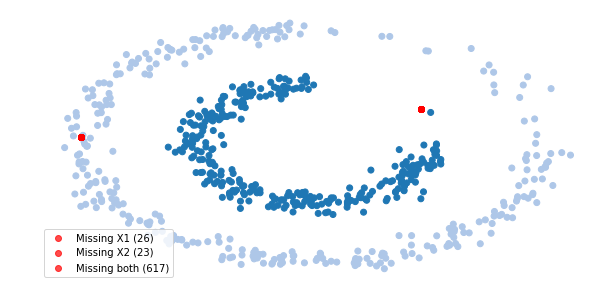

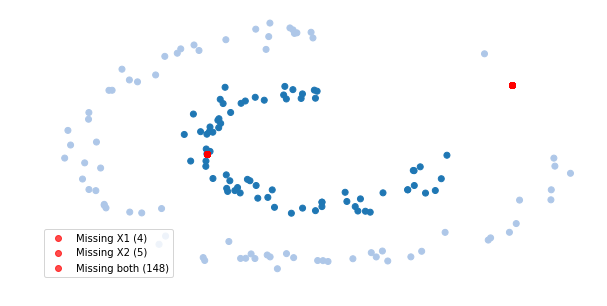

In [3]:
# Dataset default parameters
dataset_name = DATASET_NAME
num_samples = NUM_SAMPLES
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN

verbosity=2



dataset_train = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='train',
                                num_samples=int(proportion_train*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)

dataset_test = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='test',
                                num_samples=int((1-proportion_train)*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)


# Creation of the missingness
dataset_train.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)
dataset_test.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=verbosity)

#dataset_train.plot(title=True)
#dataset_test.plot(title=True)

# Get the data
X_test, Z_test, y_test = dataset_test.get_data()
X_train, Z_train, y_train = dataset_train.get_data()

In [4]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset_train=dataset_train, 
                  dataset_test=dataset_test, 
                  purpose='classification', 
                  method='no_imputations',
                  inference_imputation=False,
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

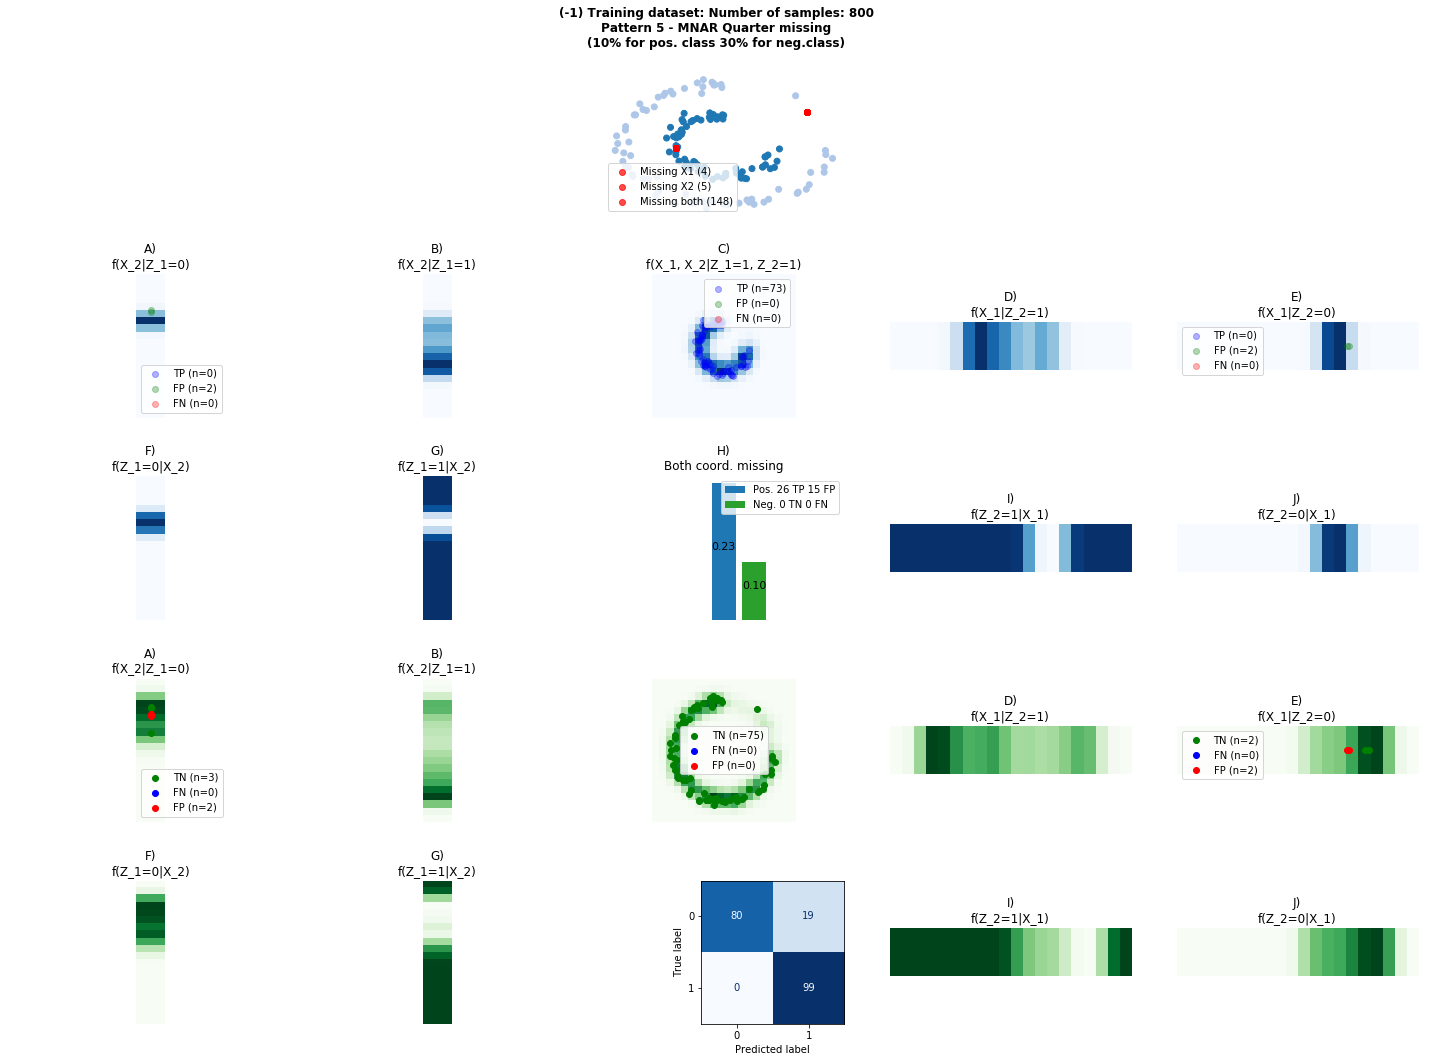

Sample: 99 positive and 99 negative samples (#p/#n=100%)



,0
Accuracy,0.904
F1 score (2 PPVxTPR/(PPV+TPR)),0.912
Matthews correlation coefficient (MCC),0.823
"Sensitivity, recall, hit rate, or true positive rate (TPR)",1.000
"Specificity, selectivity or true negative rate (TNR)",0.808
Precision or positive predictive value (PPV),0.839
Negative predictive value (NPV),1.000
Miss rate or false negative rate (FNR),0.000
False discovery rate (FDR=1-PPV),0.161
False omission rate (FOR=1-NPV),0.000


In [5]:
# Plot results
exp.plot()

In [9]:
exp()from model.neural_additive_network.model import NAM

          Attribute Name                	 type                                    	 Value or first element                                                                                                                                
          -----------------------------------------------------------------------------------------------------------------------------------------------------------------

          dataset_name                  	 str                                     	 circles                                                                                                                                               
          debug                         	 int                                     	 False                                                                                                                                                 
          verbosity                     	 int                                     	 1                                     

In [10]:
exp.dataset_train()


          Attribute Name                	 type                                    	 Value or first element                                                                                                                                
          -----------------------------------------------------------------------------------------------------------------------------------------------------------------

          dataset_name                  	 str                                     	 circles                                                                                                                                               
          num_samples                   	 int                                     	 800                                                                                                                                                   
          class_used                    	 None                                    	 None                                  

In [13]:
from model.neural_additive_network.model import NAM

array([[-0.85565791, -0.1255166 ],
       [        nan,         nan],
       [-1.04613074,  1.50343669],
       [        nan,         nan],
       [ 0.60772142, -0.68130506],
       [ 0.24490015, -1.01108786],
       [-1.71585596,  0.51623961],
       [-1.42057467,  1.02156885],
       [-0.71428867, -0.45019887],
       [-0.48467926, -0.81189619],
       [        nan,         nan],
       [-0.83258296, -0.08667221],
       [-0.56024841, -0.51981538],
       [        nan,         nan],
       [ 0.42364   , -1.63138705],
       [ 0.65462465, -0.38536945],
       [-1.20456726, -1.52719125],
       [ 0.33490183, -1.02917827],
       [-0.76954742,  0.28098469],
       [-0.27550908, -1.67179098],
       [ 0.69945452, -0.32541113],
       [-0.22325761, -1.73375608],
       [        nan,         nan],
       [-0.70431276, -0.70719787],
       [-1.15681041, -1.39957289],
       [        nan,         nan],
       [ 1.34953802, -1.34079287],
       [        nan,         nan],
       [-0.61005538,

In [ ]:
# Creation of a df for the prediction
predictions_df = pd.DataFrame({'X1':self.dataset_test.X[:,0], 
              'X2':self.dataset_test.X[:,1], 
              'Z1':[1 if not np.isnan(x) else 0 for x in self.dataset_test.X[:,0]],
              'Z2': [1 if not np.isnan(x) else 0 for x in self.dataset_test.X[:,1]],
              'y_true': y_true, 
              'y_pred': y_pred})

In [12]:
exp.predictions_df

,X1,X2,Z1,Z2,y_true,y_pred,True Positive,True Negative,False Positive,False Negative
0,-0.855658,-0.125517,1,1,1.0,1.0,1,0,0,0
1,NaN,NaN,0,0,0.0,1.0,0,0,1,0
2,-1.046131,1.503437,1,1,0.0,0.0,0,1,0,0
3,NaN,NaN,0,0,1.0,1.0,1,0,0,0
4,0.607721,-0.681305,1,1,1.0,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
193,1.680804,-0.314963,1,1,0.0,0.0,0,1,0,0
194,-0.499577,1.809205,1,1,0.0,0.0,0,1,0,0
195,NaN,NaN,0,0,0.0,1.0,0,0,1,0
196,0.852875,-0.510048,1,1,1.0,1.0,1,0,0,0


In [44]:
test_dict[0].shape

(800,)

In [60]:
features
test_dict = {i:X_test[:,i] for i in range(X_test.shape[1])}
test_dict['y_true'] = y_test
test_df = pd.DataFrame.from_dict(test_dict);test_df.columns = features + ["y_true"]
test_df

,X_1,X_2,Z_1,Z_2,y_true
0,-0.855658,-0.125517,1.0,1.0,1.0
1,-5.000000,-5.000000,0.0,0.0,0.0
2,-1.046131,1.503437,1.0,1.0,0.0
3,-5.000000,-5.000000,0.0,0.0,1.0
4,0.607721,-0.681305,1.0,1.0,1.0
...,...,...,...,...,...
193,1.680804,-0.314963,1.0,1.0,0.0
194,-0.499577,1.809205,1.0,1.0,0.0
195,-5.000000,-5.000000,0.0,0.0,0.0
196,0.852875,-0.510048,1.0,1.0,1.0


In [54]:
# Select the kind of dataset we would like to use for training and for inference.
    if missing_treatment == 'encoding':

        # For the training, we encode the training set and so the test set. 
        self.dataset_train.subset(missing_treatment='encoding')
        self.dataset_test.subset(missing_treatment='encoding')


    elif missing_treatment == 'imputation':
        self.dataset_train.subset(missing_treatment='imputation')


    if use_Z:
        X_train, X_test = np.concatenate([self.dataset_train.X, self.dataset_train.Z], axis=1), np.concatenate([self.dataset_test.X, self.dataset_test.Z], axis=1)
    else:
        X_train, X_test = self.dataset_train.X, self.dataset_test.X
    y_train, y_test = self.dataset_train.y.squeeze(), self.dataset_test.y.squeeze()
    
    # Create the df associated to the test sample 
    test_dict = {i:X_test[:,i] for i in range(X_test.shape[1])}
    test_dict['y_true'] = y_test
    test_df = pd.DataFrame.from_dict(test_dict);test_df.columns = features + ["y_true"]
    data_train = TabularData(X=X_train, y=y_train)
    data_test = TabularData(X=X_test, y=y_test) 
    

IndentationError: unexpected indent (<ipython-input-54-8d2169d19f67>, line 2)

In [ ]:
    d_train, d_test = train_test_split(data, test_size=args['test_size'])    

    data_train = TabularData(d_train[features].values, d_train[response].values)

In [19]:
d_train

,sex,age,race,length_of_stay,priors_count,charge_degree,is_recid
6627,0,41,0,2.0,7,0,1
6605,0,36,2,2.0,0,0,0
6044,1,33,0,2.0,9,1,1
2958,1,22,0,2.0,0,0,1
744,1,21,0,2.0,0,0,1
...,...,...,...,...,...,...,...
2456,1,36,0,2.0,15,0,0
1547,1,46,0,1.0,0,0,0
5794,1,50,2,10.0,1,0,0
5101,1,27,2,29.0,1,1,1


# Experiment X) Neural Additive Networks

In [80]:


args = {'no_replicates': 2,
         'model': {'no_features': 4,
                  'hidden_sizes': [64, 64, 32],
                  'dropout_rate': 0.1,
                  'feature_dropout': 0.05,
                  'use_exu': False},
         'training': {'regression': False,
                      'batch_size': 16,
                      'max_epochs': 2,
                      'verbosity': 20,
                      'learning_rate': 0.0002,
                      'weight_decay': 0.0,
                      'output_penalty': 0.2},
         'plotting': {'roc': {'size': [5, 3], 
                              'fname': None},
                      'shapes': {'ncols': 4, 
                                 'size': [10, 10], 
                                 'fname': None}}}
    
sys.path.insert(0, '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models')


import yaml
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nam import NAM
from src.utils import TabularData, train_model, eval_model
from src.plots import plot_roc_curves


In [82]:
import matplotlib
matplotlib.use('Agg')

	===== Replicate no. 1 =====

Encoding 800 missing values with -5.
Encoding 198 missing values with -5.
Epoch: 1/2;	 Batch: 1/50;	 Err: 0.773
Epoch: 1/2;	 Batch: 21/50;	 Err: 0.794
Epoch: 1/2;	 Batch: 41/50;	 Err: 0.765

	 Epoch finished in 0.14 seconds!

Epoch: 2/2;	 Batch: 1/50;	 Err: 0.740
Epoch: 2/2;	 Batch: 21/50;	 Err: 0.754
Epoch: 2/2;	 Batch: 41/50;	 Err: 0.762

	 Epoch finished in 0.12 seconds!

	===== Replicate no. 2 =====

Encoding 800 missing values with -5.
Encoding 198 missing values with -5.
Epoch: 1/2;	 Batch: 1/50;	 Err: 0.753
Epoch: 1/2;	 Batch: 21/50;	 Err: 0.845
Epoch: 1/2;	 Batch: 41/50;	 Err: 0.749

	 Epoch finished in 0.12 seconds!

Epoch: 2/2;	 Batch: 1/50;	 Err: 0.743
Epoch: 2/2;	 Batch: 21/50;	 Err: 0.758
Epoch: 2/2;	 Batch: 41/50;	 Err: 0.741

	 Epoch finished in 0.12 seconds!



<Figure size 640x480 with 0 Axes>

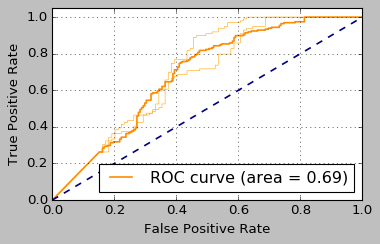

NameError: name 'figsize' is not defined

In [81]:
use_Z = True
self = exp
missing_treatment = 'encoding'
features = ['X_1', 'X_2', 'Z_1', 'Z_2']
verbosity=1


results = []
for i in range(args['no_replicates']):        
    print('\t===== Replicate no. {} =====\n'.format(i + 1))
    
    dataset_train = DatasetGenerator(dataset_name=dataset_name, 
                                purpose='train',
                                num_samples=int(proportion_train*num_samples), 
                                imbalance_ratio=imbalance_ratio, 
                                verbosity=verbosity)

    dataset_test = DatasetGenerator(dataset_name=dataset_name, 
                                    purpose='test',
                                    num_samples=int((1-proportion_train)*num_samples), 
                                    imbalance_ratio=imbalance_ratio, 
                                    verbosity=verbosity)


    # Creation of the missingness
    dataset_train.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=0)
    dataset_test.generate_missing_coordinates(missingness_pattern=missingness_pattern, verbosity=0)
    
    # Create the experiments
    self = Experiments(dataset_name, 
                  dataset_train=dataset_train, 
                  dataset_test=dataset_test, 
                  purpose='classification', 
                  method='NAN',
                  inference_imputation=False,
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)
    
    
    
    # Select the kind of dataset we would like to use for training and for inference.
    if missing_treatment == 'encoding':

        # For the training, we encode the training set and so the test set. 
        self.dataset_train.subset(missing_treatment='encoding')
        self.dataset_test.subset(missing_treatment='encoding')


    elif missing_treatment == 'imputation':
        self.dataset_train.subset(missing_treatment='imputation')


    if use_Z:
        X_train, X_test = np.concatenate([self.dataset_train.X, self.dataset_train.Z], axis=1), np.concatenate([self.dataset_test.X, self.dataset_test.Z], axis=1)
    else:
        X_train, X_test = self.dataset_train.X, self.dataset_test.X

    y_train, y_test = self.dataset_train.y.squeeze(), self.dataset_test.y.squeeze()
    
    # Create the df associated to the test sample 
    test_dict = {i:X_test[:,i] for i in range(X_test.shape[1])}
    test_dict['y_true'] = y_test
    test_df = pd.DataFrame.from_dict(test_dict);test_df.columns = features + ["y_true"]
    
    
    # Create the PyTorch Datasets
    data_train = TabularData(X=X_train, y=y_train)
    data_test = TabularData(X=X_test, y=y_test) 
    
    model = NAM(**args['model'])
    model = model.double()

    train_model(model, data_train, **args['training'])
    y_, p_ = eval_model(model, data_test)
    
    res = (pd.DataFrame(p_, columns = features, index=test_df.index)
                .add_suffix('_partial')
                .join(test_df)
                .assign(y_pred = y_)
                .assign(replicate = i))

    results.append(res)

results = pd.concat(results)

plot_roc_curves(results, 'y_pred','y_true', **args['plotting']['roc'])

plot_shape_functions(results, features, **args['plotting']['shapes']) 

In [15]:
sys.path.insert(0, '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models')


import yaml
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nam import NAM
from src.utils import TabularData, train_model, eval_model
from src.plots import plot_roc_curves, plot_shape_functions
from responsibly.dataset import COMPASDataset

def load_data():
    # Fetch data and subset columns
    cols = ['sex', 'age','race', 'length_of_stay', 'priors_count', 'c_charge_degree', 'is_recid']
    compas = COMPASDataset()
    compas = compas.df
    compas = compas[cols]

    # Get length of stay in days
    compas['length_of_stay'] /= np.timedelta64(1, 'D')
    compas['length_of_stay'] = np.ceil(compas['length_of_stay'])

    # Rename column
    compas = compas.rename(columns = {'c_charge_degree' : 'charge_degree'})
    return compas

def main(args):
    data = load_data()
    cols = data.columns

    features, response = cols[:-1], cols[-1]
    data, encoders = encode_data(data)

    results = []
    for i in range(args['no_replicates']):        
        print('\t===== Replicate no. {} =====\n'.format(i + 1))

        d_train, d_test = train_test_split(
            data, 
            test_size=args['test_size']
        )    

        data_train = TabularData(
            d_train[features].values, 
            d_train[response].values
        )

        data_test = TabularData(
            d_test[features].values, 
            d_test[response].values
        )        
    
        model = NAM(**args['model'])
        model = model.double()

        train_model(model, data_train, **args['training'])
        y_, p_ = eval_model(model, data_test)
        
        res = (
            pd
            .DataFrame(p_, columns = features, index = d_test.index)
            .add_suffix('_partial')
            .join(d_test)
            .assign(prediction = y_)   
            .assign(replicate = i)         
        )
        
        results.append(res)
    
    results = pd.concat(results)
    results = decode_data(results, encoders)

    plot_roc_curves(
        results, 
        'prediction',
        'is_recid', 
        **args['plotting']['roc']
    )

    plot_shape_functions(
        results, 
        features, 
        **args['plotting']['shapes']
    )    
with open('/Users/samperochon/Duke/Ongoing/Neural-Additive-Models/config.yml', 'r') as f:
    args = yaml.safe_load(f)

In [16]:
data = load_data()
cols = data.columns

features, response = cols[:-1], cols[-1]
data, encoders = encode_data(data)

args = {'no_replicates': 2,
         'test_size': 500,
         'model': {'no_features': 6,
                  'hidden_sizes': [64, 64, 32],
                  'dropout_rate': 0.1,
                  'feature_dropout': 0.05,
                  'use_exu': False},
         'training': {'regression': False,
                      'batch_size': 16,
                      'max_epochs': 5,
                      'verbosity': 20,
                      'learning_rate': 0.0002,
                      'weight_decay': 0.0,
                      'output_penalty': 0.2},
         'plotting': {'roc': {'size': [5, 3], 
                              'fname': '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models/results/roc.png'},
                      'shapes': {'nrows': 3, 
                                 'size': [10, 10], 
                                 'fname': '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models/results/shapes.png'}}}

d_train, d_test = train_test_split(data, test_size=args['test_size'])    

data_train = TabularData(d_train[features].values, d_train[response].values)


<Figure size 640x480 with 0 Axes>

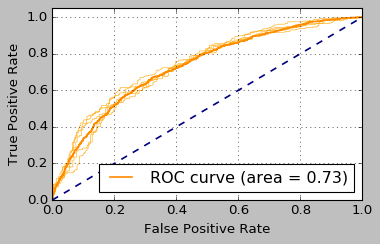

In [54]:
pred_col = 'prediction'
resp_col = 'is_recid'
plot_roc_curves(results, 'prediction','is_recid', **args['plotting']['roc'])\

In [90]:
d_test

,sex,age,race,length_of_stay,priors_count,charge_degree,is_recid
5777,0,41,2,1.0,9,1,1
3484,1,39,2,19.0,5,0,0
6433,0,25,0,1.0,5,0,1
5003,1,54,0,1.0,1,0,0
6991,1,27,3,4.0,4,0,1
...,...,...,...,...,...,...,...
291,1,46,2,15.0,3,0,0
70,1,45,3,242.0,6,0,1
2020,1,34,2,117.0,0,0,0
3881,1,29,2,4.0,2,0,0


In [25]:

args = {'no_replicates': 2,
         'test_size': 500,
         'model': {'no_features': 6,
                  'hidden_sizes': [64, 64, 32],
                  'dropout_rate': 0.1,
                  'feature_dropout': 0.05,
                  'use_exu': False},
         'training': {'regression': False,
                      'batch_size': 16,
                      'max_epochs': 5,
                      'verbosity': 20,
                      'learning_rate': 0.0002,
                      'weight_decay': 0.0,
                      'output_penalty': 0.2},
         'plotting': {'roc': {'size': [5, 3], 
                              'fname': '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models/results/roc.png'},
                      'shapes': {'nrows': 3, 
                                 'size': [10, 10], 
                                 'fname': '/Users/samperochon/Duke/Ongoing/Neural-Additive-Models/results/shapes.png'}}}
y_, p_ = eval_model(model, data_test)

In [29]:
model.eval()
with torch.no_grad():
    y_, p_ = model(data.X)   
    y_ = y_.flatten().numpy()
    p_ = p_.numpy()

array([[ 0.02168538, -0.01244706, -0.02927503, -0.03675742, -0.15016623,
         0.01845463],
       [ 0.02168538,  0.03052931, -0.02927503, -0.03675742, -0.15016623,
         0.01845463],
       [ 0.02168538,  0.06998082,  0.04991305,  0.03079464, -0.05147158,
         0.01845463],
       ...,
       [-0.04469942,  0.06998082, -0.02927503, -0.03675742, -0.05147158,
         0.01845463],
       [ 0.02168538, -0.01665269, -0.02927503, -0.01028656,  0.09989587,
         0.01845463],
       [ 0.02168538, -0.02488807,  0.04991305, -0.01028656,  0.25650142,
         0.01845463]])

	===== Replicate no. 1 =====

Epoch: 1/5;	 Batch: 1/355;	 Err: 1.400
Epoch: 1/5;	 Batch: 21/355;	 Err: 1.076
Epoch: 1/5;	 Batch: 41/355;	 Err: 1.244
Epoch: 1/5;	 Batch: 61/355;	 Err: 0.851
Epoch: 1/5;	 Batch: 81/355;	 Err: 0.929
Epoch: 1/5;	 Batch: 101/355;	 Err: 0.941
Epoch: 1/5;	 Batch: 121/355;	 Err: 0.798
Epoch: 1/5;	 Batch: 141/355;	 Err: 0.968
Epoch: 1/5;	 Batch: 161/355;	 Err: 1.169
Epoch: 1/5;	 Batch: 181/355;	 Err: 0.610
Epoch: 1/5;	 Batch: 201/355;	 Err: 0.884
Epoch: 1/5;	 Batch: 221/355;	 Err: 0.833
Epoch: 1/5;	 Batch: 241/355;	 Err: 0.785
Epoch: 1/5;	 Batch: 261/355;	 Err: 0.901
Epoch: 1/5;	 Batch: 281/355;	 Err: 0.691
Epoch: 1/5;	 Batch: 301/355;	 Err: 0.753
Epoch: 1/5;	 Batch: 321/355;	 Err: 0.726
Epoch: 1/5;	 Batch: 341/355;	 Err: 0.893

	 Epoch finished in 1.23 seconds!

Epoch: 2/5;	 Batch: 1/355;	 Err: 0.815
Epoch: 2/5;	 Batch: 21/355;	 Err: 0.659
Epoch: 2/5;	 Batch: 41/355;	 Err: 0.829
Epoch: 2/5;	 Batch: 61/355;	 Err: 0.840
Epoch: 2/5;	 Batch: 81/355;	 Err: 0.732
Epo

<Figure size 432x288 with 0 Axes>

<Figure size 400x240 with 0 Axes>

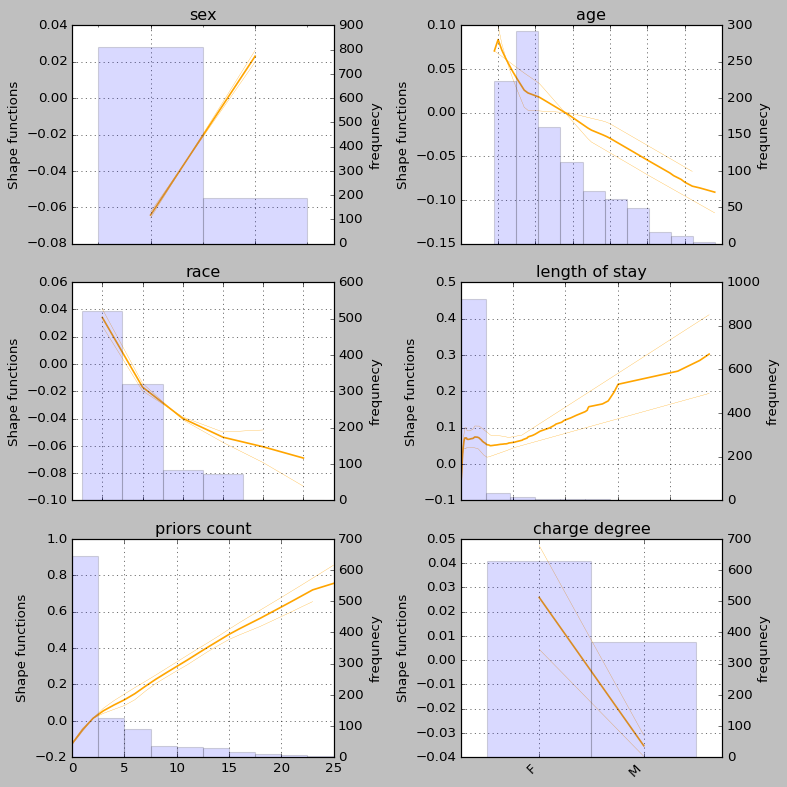

In [17]:
results = []
for i in range(2):#args['no_replicates']):        
    print('\t===== Replicate no. {} =====\n'.format(i + 1))

    d_train, d_test = train_test_split(data, test_size=args['test_size'])    

    data_train = TabularData(d_train[features].values, d_train[response].values)

    data_test = TabularData(d_test[features].values, d_test[response].values)        

    model = NAM(**args['model'])
    model = model.double()

    train_model(model, data_train, **args['training'])
    y_, p_ = eval_model(model, data_test)

    res = (pd.DataFrame(p_, columns = features, index = d_test.index)
            .add_suffix('_partial')
            .join(d_test)
            .assign(prediction = y_)   
            .assign(replicate = i))

    results.append(res)

results = pd.concat(results)
results = decode_data(results, encoders)

plot_roc_curves(results, 'prediction','is_recid', **args['plotting']['roc'])

plot_shape_functions(results, features, **args['plotting']['shapes'])    

In [13]:
results

,sex_partial,age_partial,race_partial,length_of_stay_partial,priors_count_partial,charge_degree_partial,sex,age,race,length_of_stay,priors_count,charge_degree,is_recid,prediction,replicate
3773,0.016644,-0.000349,0.030298,0.089675,-0.039745,0.020826,Male,29,African-American,41.0,1,F,0,0.525018,1
205,-0.001543,0.028745,0.039293,-0.026192,-0.008566,0.028039,Male,26,African-American,2.0,2,F,1,0.512110,0
1332,-0.001543,-0.033279,-0.034406,-0.026192,-0.008566,0.028039,Male,43,Caucasian,2.0,2,F,0,0.478195,0
1155,-0.001543,0.035854,0.039293,-0.026192,-0.008566,0.028039,Male,23,African-American,2.0,2,F,1,0.513886,0
1437,-0.093342,-0.091479,-0.034406,-0.026192,-0.008566,0.028039,Female,60,Caucasian,2.0,2,F,0,0.440958,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,-0.001543,0.031115,-0.034406,-0.059465,-0.165080,-0.031723,Male,25,Caucasian,1.0,0,M,0,0.432311,0
6277,0.016644,-0.025189,-0.043877,0.011335,0.056452,-0.056195,Male,47,Other,4.0,3,M,0,0.485498,1
3514,-0.001543,0.070181,-0.056546,-0.026192,0.054869,-0.031723,Male,20,Other,2.0,3,M,1,0.499430,0
4658,0.016644,0.008080,0.030298,0.039561,0.056452,-0.056195,Male,23,African-American,7.0,3,M,0,0.519402,1


# Experiment X) Explainable Boosting Machine 

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import SGDClassifier, LogisticRegression

from interpret.glassbox import ExplainableBoostingClassifier


def format_n(x):
    return "{0:.3f}".format(x)

random_state = 47
n_splits = 5


model = ExplainableBoostingClassifier(n_jobs=-1, random_state=random_state)

model.fit(X,y)
from interpret import show

ebm_global = model.explain_global()
show(ebm_global)

ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=random_state)
scores = cross_validate(model, X, y, scoring='roc_auc', cv=ss, n_jobs=None, return_estimator=True)

record = dict()
record['model_name'] = 'EBM'
record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
record['fit_time_std'] = format_n(np.std(scores['fit_time']))
record['test_score_mean'] = format_n(np.mean(scores['test_score']))
record['test_score_std'] = format_n(np.std(scores['test_score']))
record

# Experiment X) XGBoost

In [ ]:
import xgboost as xgb


# Normalize the feature space to it has 0 mean and unitary std. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from xgboost import XGBClassifier
from ml import visualize_classifier, my_model, plot_PR_and_ROC_curves, evaluate_model
from sklearn.model_selection import train_test_split
def test_model(X=None,y=None,model=None,df=None, num_cv=None, verbose=False, th=.5, **kwargs):
    """
    Test model and append results to the df. 
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = evaluate_model(num_cv=num_cv, 
                                                                       model=model,  
                                                                       X=X, 
                                                                       y=y, 
                                                                       threshold=th, 
                                                                       classes_names=['TD', 'ASD'],verbose=verbose, **kwargs)
    
    # Store the resutls
    df = df.append({'ExperimentName':model.name, 
                    'recall':recall, 
                    'precision':precision, 
                    'fpr':fpr, 
                    'tpr':tpr, 
                    'ths_roc': ths_roc,
                    'ths_pr': ths_pr},  ignore_index=True)
    
    return df

def plot_results_PR_and_ROC(df):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        """
        Plot the pr and roc curves for the results saved in the pandas df. 
        """
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go    

        """
        Define plot asthetics
        """
        ref_color = '#888E90'  # Color of reference lines
        colors = plt.get_cmap(name='Paired').colors  # color of each algorithm

        """
        PR curve
        """
        # (1) Initialize figures 
        fig = make_subplots(rows=1, cols=2)

        # (2) Add iso-fscore traces to PR curve
        # Add the iso-levels of f1
        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            yy = f_score * x / (2 * x - f_score)
            fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], name='f1={:2.1f}'.format(f_score), 
                        line=dict(color=ref_color)), row=1, col=1)
        fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
        fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

        # (3) Add PR curve associated to each experiment
        for i,row in df.iterrows():
            precision = row['precision']
            recall = row['recall']
            name = row['ExperimentName']
            ths_pr = row['ths_pr']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=precision,y=recall, name=name, 
                                  line=dict(color=color), hovertext=ths_pr), row=1, col=1)

        """
        Plot ROC curve
        """
        # Init plot 
        fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10),
                            line=dict(color=ref_color)), row=1, col=2)

        for i, row in df.iterrows():
            fpr = row['fpr']
            tpr = row['tpr']
            ths = row['ths_roc']
            name = row['ExperimentName']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=fpr,y=tpr, line=dict(color=color), hovertext=ths), row=1, col=2)
        fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
        fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
        fig.update_layout(title="PR AND ROC curves")
    return fig

def test_set_of_features(data, feats, name, df, th=.5, algos=['knn']):

    
    filter_criteria =  ' `diagnosis` in [0,1] and `age` <= 36'
    
    # Define X and y for this example    
    X  = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()

    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        print('-------------------------')
        print('{} || {} '.format(name, algo))
        print('-------------------------')
        
        for cv in [16]:
            model = my_model(method=algo, name='{}::{}-{}cv'.format(name, algo, cv), **parameters[algo])            
            df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=th)   
    return df


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, stratify=y)


parameters={'knn': {}, 
            'xgboost' : {}, 
            'nb': {}}

parameters['xgboost'] = {'n_estimators' : 100,
                         'max_depth' : 2,
                         'min_child_weight' : 3,
                         'colsample_bytree' : .8, 
                         'colsample_bynode' : .8
                        }

parameters_fit={'knn': {}, 
                'xgboost' : {}}
parameters_fit['xgboost'] = {'early_stopping_rounds' : 5,
                             #'eval_set' : [(test_X, test_y)],
                             'verbose' : 0}



#model = my_model(method='xgboost', name='xgboost', **parameters['xgboost'])
#model.fit(X, y, balanced=True, **parameters_fit['xgboost'])

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

algos = ['knn', 'nb', 'xgboost']
# Create a df to store all the results of each experiement
results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

    
plt.figure(figsize=[20,10])
# Check the methods and compare fitting all data (cv=0) with CV
for i,algo in enumerate(algos):
    for cv in [0]:
        model = my_model(method=algo, name='{}-{}cv'.format(algo, cv), **parameters[algo])
        results_summary = test_model(X=X,y=y,df=results_summary, model=model, num_cv=cv)    
        
fig = plot_results_PR_and_ROC(results_summary)
fig.show()


from sklearn.metrics import plot_roc_curve
features_dict = {'all':['proportion_of_name_call_responses', 'average_response_to_name_delay',
                         'gaze_silhouette_score', 'mean_gaze_percent_right', 'FP_gaze_speech_correlation',
                         'S_postural_sway', 'NS_postural_sway',
                         'pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error'],
                 'all+age':['age','proportion_of_name_call_responses', 'average_response_to_name_delay',
                             'gaze_silhouette_score', 'mean_gaze_percent_right', 'FP_gaze_speech_correlation',
                             'S_postural_sway', 'NS_postural_sway',
                             'pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error'],
                 
                 'gaze' : ['BB_gaze_percent_right', 'BB_gaze_silhouette_score', 'S_gaze_percent_right', 
                           'S_gaze_silhouette_score', 'FP_gaze_speech_correlation','FP_gaze_silhouette_score'],
                 
                 'RTN' : ['proportion_of_name_call_responses', 'average_response_to_name_delay'],
                 
                 'postural' : ['S_postural_sway', 'NS_postural_sway'],
                 
                 'touch' : ['pop_rate', 'average_force_applied', 'average_length', 'number_of_touches', 'average_touch_duration','average_error']
                }
results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

for name, feats in features_dict.items():
    print('\n')
    print('-------------------------')
    print('{} '.format(name))
    print('-------------------------')

    filter_criteria =  ' `diagnosis` in [0,1] and `age` <= 36'
    
    # Define X and y for this example    
    X  = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()
    
    model = my_model(method='xgboost', name='xgboost', **parameters['xgboost'])
    model.fit(X, y, balanced=True)
    model.model.get_booster().feature_names = feats
    
    #df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=.5)
    plot_roc_curve(model, X, y, name=name) 
    xgb.plot_importance(model.model.get_booster(),  height=0.7)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    xgb.plot_tree(model.model.get_booster(), num_trees=model.model.best_iteration, ax=ax)
    plt.show()

    
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

xgb.plot_tree(model.model.get_booster(), num_trees=model.model.best_iteration, ax=ax)

#model.model.get_booster().feature_names = feats
xgb.plot_importance(model.model.get_booster(),  height=0.7)


from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
import xgboost as xgb
import multiprocessing


xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                               'n_estimators': [50, 100, 200]}, verbose=1,
                   n_jobs=2)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)


# Experiment on the data imputation confidence! 

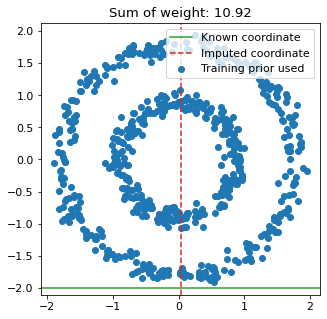

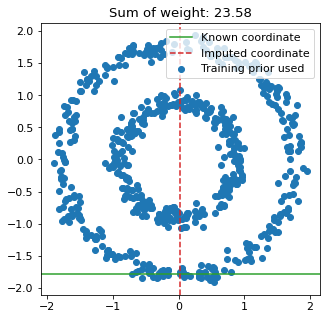

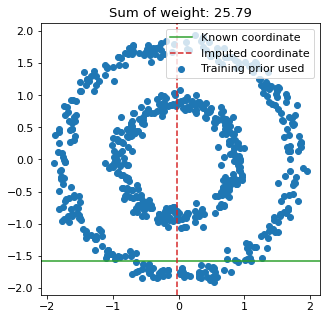

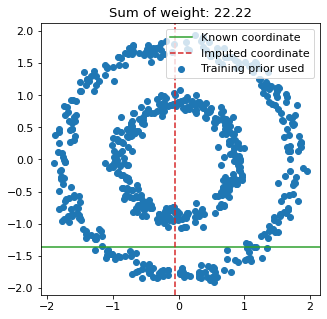

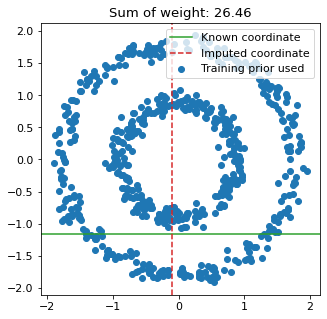

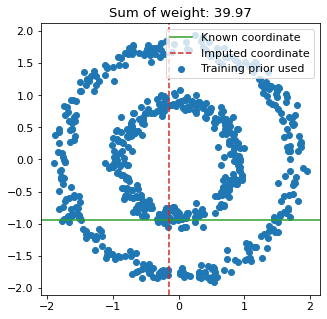

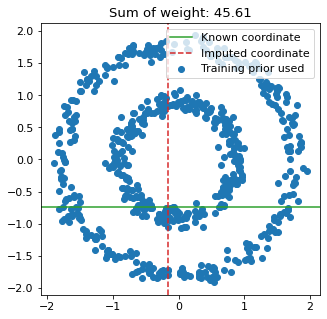

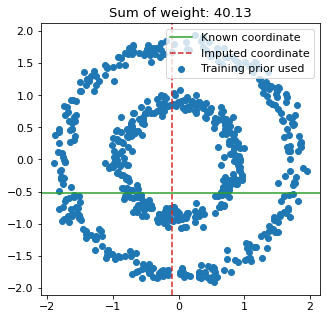

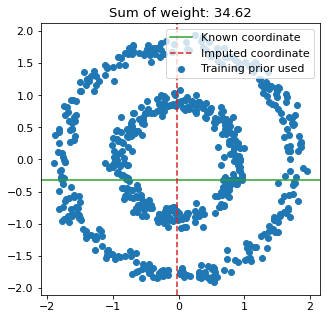

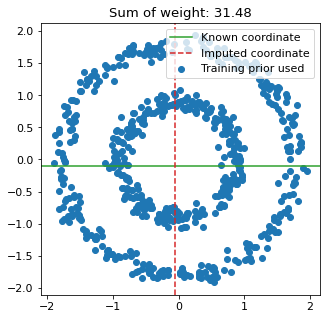

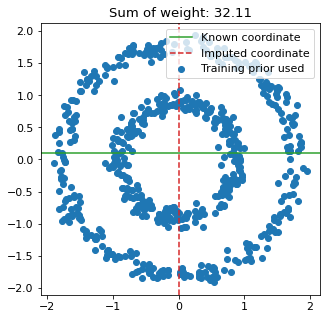

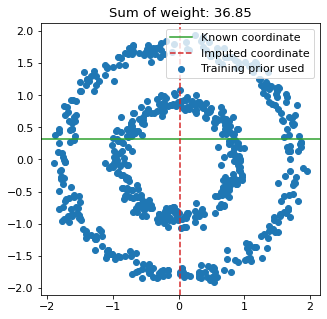

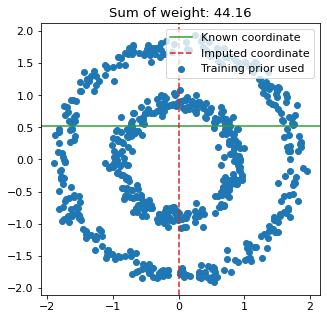

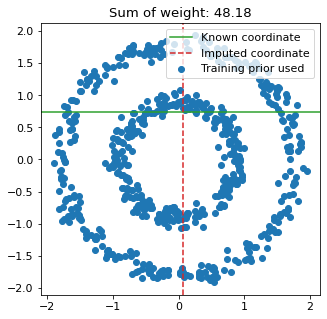

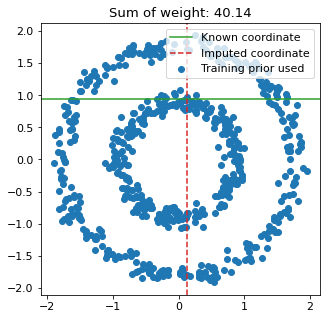

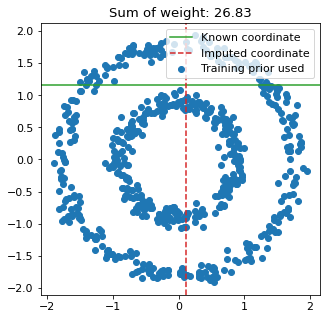

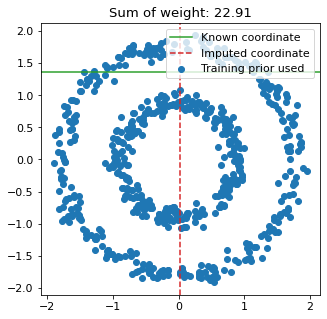

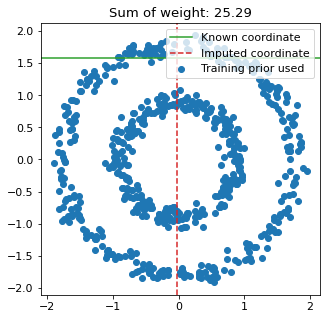

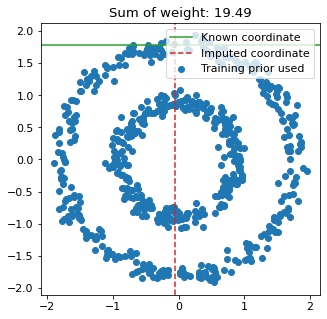

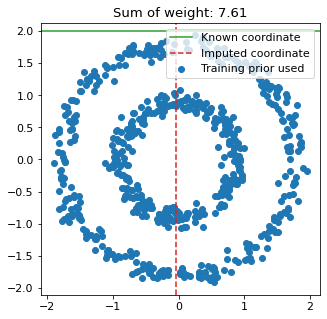

In [73]:



X_i = self.dataset_test.X[5]
w_list = []
a_list = np.linspace(-2, 2, 20)
for a in np.linspace(-2, 2, 20):
    X_i = np.array([np.nan, a])
    from copy import deepcopy
    h=bandwidth
    """
    Contribution of the X_i sample to the estimation of the pdf of X at x. 
    X_prior contains the samples for which there is no missing values, which are used as prior when the contribution of sample with partially missing data is calculated.
    """
    k = X_i.shape[0]  # dimension of the space of samples. 


    # Copy the feature value 
    hat_X_i = deepcopy(X_i)


    # Perform imputation if needed
    coords_missing = np.isnan(X_i)  # unknown coordinates of X_i
    for j in range(k):        
        if coords_missing[j]:  # we don't know the j-th coordinate, we need to impute it

            # We use the term associate to the j-th coordinate for the 
            # rest of the samples in the training set (for which the j-th component is know).
            # The contribution of each term is weighted with the distance to the sample hyperplane.
            hat_X_ij = 0
            Ws = 1e-10  # eps
            for X_p in X_prior:
                w_p = W(X_i, X_p)
                hat_X_ij += w_p * X_p[j]
                Ws += w_p
            hat_X_ij /= Ws

            hat_X_i[j] = hat_X_ij



    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X_prior[:,0], X_prior[:,1], label='Training prior used')
    if coords_missing[0]:
        ax.axhline(y=X_i[1], color='tab:green', label='Known coordinate')
        ax.axvline(x=hat_X_i[0], color='tab:red', linestyle='--',  label='Imputed coordinate')
    elif coords_missing[1]:
        ax.axvline(x=X_i[0], color='tab:green', label='Known coordinate')
        ax.axhline(y=hat_X_i[1], color='tab:red', linestyle='-.', label='Imputed coordinate')
    ax.set_title("Sum of weight: {:.2f}".format(Ws))
    plt.legend()
    w_list.append(Ws)

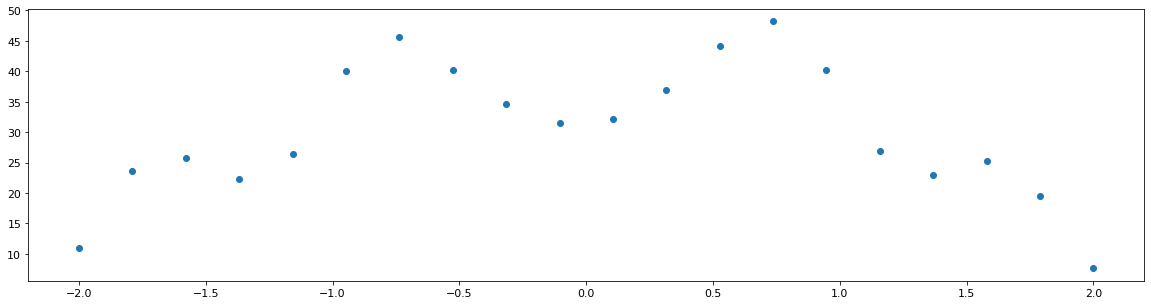

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.scatter(a_list, w_list, label='Training prior used')

(array([ 2.,  1.,  9.,  7.,  7.,  5.,  7.,  7.,  8.,  3.,  8.,  1.,  4.,
         3.,  3.,  1.,  8.,  1.,  2.,  2.,  6.,  5.,  3.,  8.,  7., 11.,
        10.,  7., 10., 12., 12., 12., 10.,  9.,  8., 11.,  8.,  9.,  7.,
         5.,  5.,  8., 13., 12.,  5., 11.,  6.,  6.,  5.,  6.,  7.,  6.,
        10.,  4.,  3.,  5.,  6., 10.,  9.,  8.,  5.,  6.,  6.,  9.,  7.,
         4., 14., 14., 11., 13., 10., 10.,  9.,  9.,  3.,  3.,  5.,  5.,
         3.,  3.,  2.,  4.,  4.,  2.,  9.,  2.,  4.,  4.,  8.,  5.,  4.,
         5.,  8.,  7.,  6.,  3.,  4.,  4.,  1.,  1.]),
 array([-1.90212367, -1.86353119, -1.82493871, -1.78634622, -1.74775374,
        -1.70916126, -1.67056877, -1.63197629, -1.5933838 , -1.55479132,
        -1.51619884, -1.47760635, -1.43901387, -1.40042139, -1.3618289 ,
        -1.32323642, -1.28464393, -1.24605145, -1.20745897, -1.16886648,
        -1.130274  , -1.09168152, -1.05308903, -1.01449655, -0.97590406,
        -0.93731158, -0.8987191 , -0.86012661, -0.82153413, -0.782941

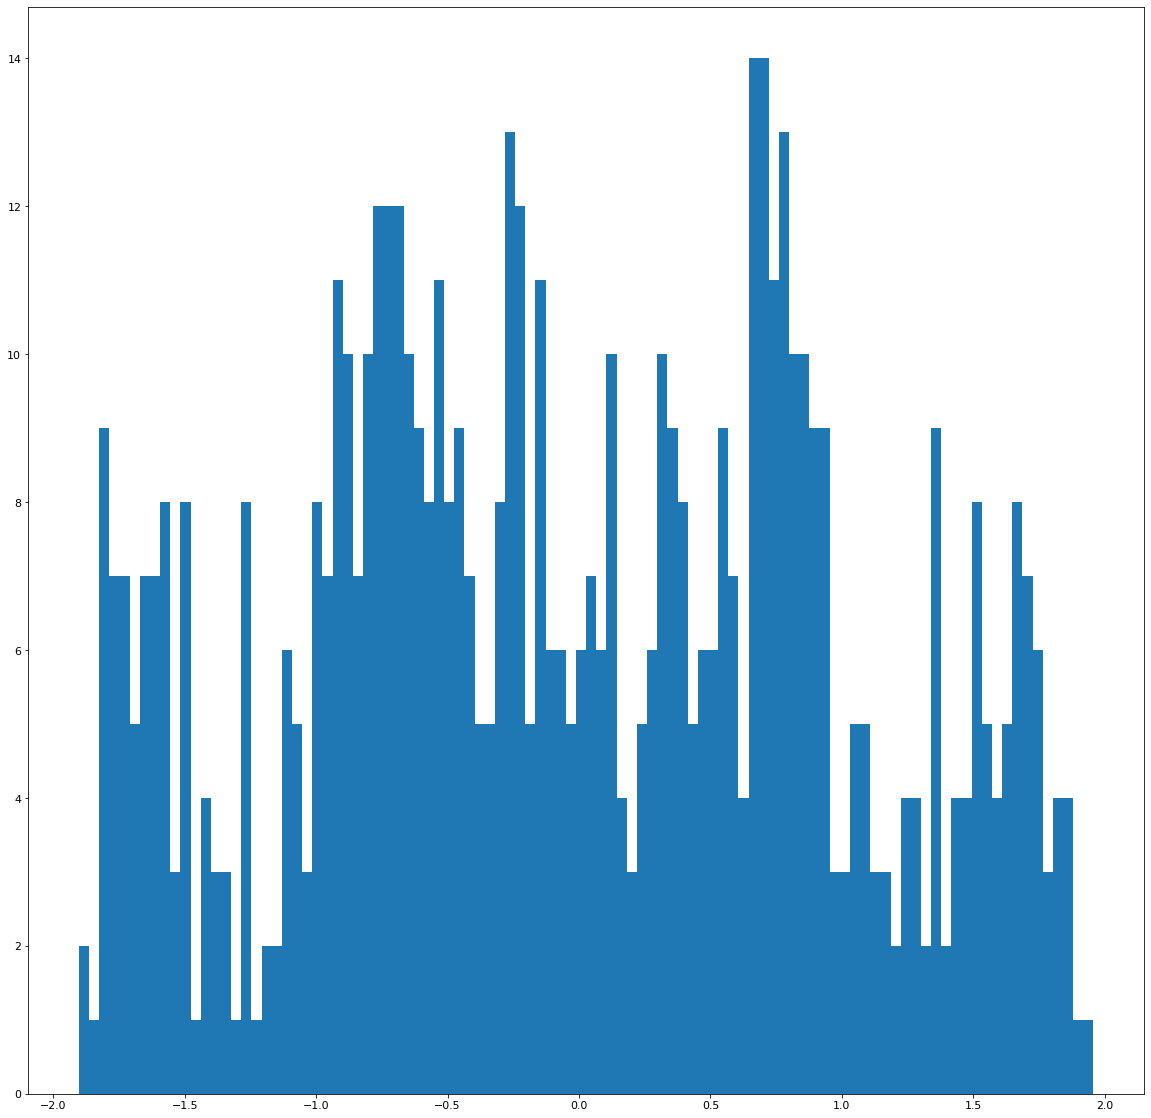

In [80]:
fi(20,20)
plt.hist(X_prior[:,0], bins=100)

In [77]:
X_prior

array([[-1.77376447,  0.10066745],
       [-0.51293983,  0.72030419],
       [ 0.93408859, -0.02222138],
       ...,
       [ 0.88751608, -0.38326858],
       [ 0.4311868 ,  0.73814206],
       [ 0.15760208,  0.78081698]])